In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install torchmetrics
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 38.2 MB/s eta 0:00:00


In [2]:
# !rm -r Training
# !rm -r Testing
# !rm -r archive.zip
!unzip archive.zip

Archive:  archive.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  inflating: Testing/glioma_t

In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from google.colab import drive
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms
from torchmetrics import AUROC

import matplotlib.pyplot as plt
import seaborn as sns

from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    Resize
)
from monai.utils import set_determinism
import random

generator = random.Random()

set_determinism(seed=44)
fgbg = cv2.createBackgroundSubtractorMOG2()

classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

def get_image_list(data_dir):
  image_paths = []
  labels = []

  for class_name in os.listdir(data_dir):
      class_dir = os.path.join(data_dir, class_name)
      if os.path.isdir(class_dir):
        if class_name == 'glioma_tumor':
          label = 0
        elif class_name == 'meningioma_tumor':
          label = 1
        elif class_name == 'no_tumor':
          label = 2
        elif class_name == 'pituitary_tumor':
          label = 3
        else:
          continue

        for image_name in os.listdir(class_dir):
          image_path = os.path.join(class_dir, image_name)
          image_paths.append(image_path)
          labels.append(label)
  return image_paths, labels

# Cerinta 1

class BrainTumorDataset(Dataset):
  def __init__(self, image_paths, labels, transforms, type_set):
    self.image_paths, self.labels, self.transforms, self.type_set = image_paths, labels, transforms, type_set

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    label = self.labels[idx]

    image = cv2.imread(image_path)

    image = self.transforms(image)

    return image, label



In [4]:
  # Cerinta 2

  def get_splited_train_data(val_frac = 0.2, train_frac = 0.8):
    image_paths, labels = get_image_list("/content/Training")
    length = len(image_paths)
    train_length = int(train_frac * length)
    indices = np.arange(length)
    np.random.shuffle(indices)

    val_split = int(val_frac * length)
    val_indices = indices[:val_split]
    train_indices = indices[val_split:train_length]

    train_x = [image_paths[i] for i in train_indices]
    train_y = [labels[i] for i in train_indices]

    val_x = [image_paths[i] for i in val_indices]
    val_y = [labels[i] for i in val_indices]

    return train_x, train_y, val_x, val_y
  def get_test_data():
    image_paths, labels = get_image_list("/content/Testing")
    return image_paths, labels

In [5]:
# Cerinta 3

def visualize_class_distribution(labels, title):
  sns.countplot(x=labels)
  plt.title(title)
  plt.xlabel("Class")
  plt.ylabel("Number of Samples")
  plt.show()


train_x, train_y, val_x, val_y = get_splited_train_data()

test_x, test_y = get_test_data()

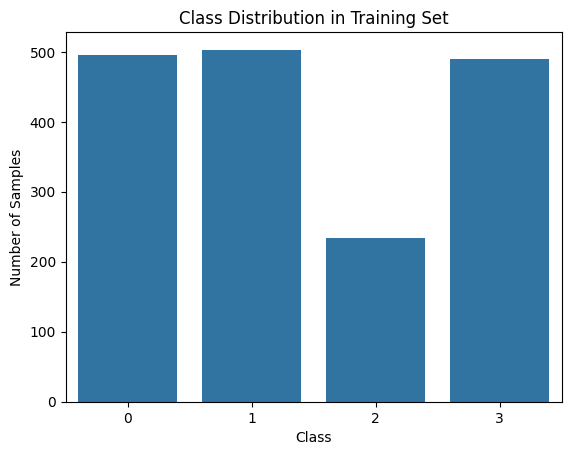

In [6]:
visualize_class_distribution(train_y, "Class Distribution in Training Set")

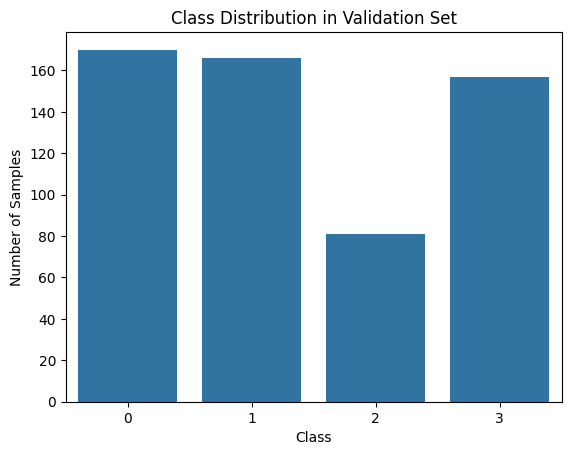

In [7]:
visualize_class_distribution(val_y, "Class Distribution in Validation Set")

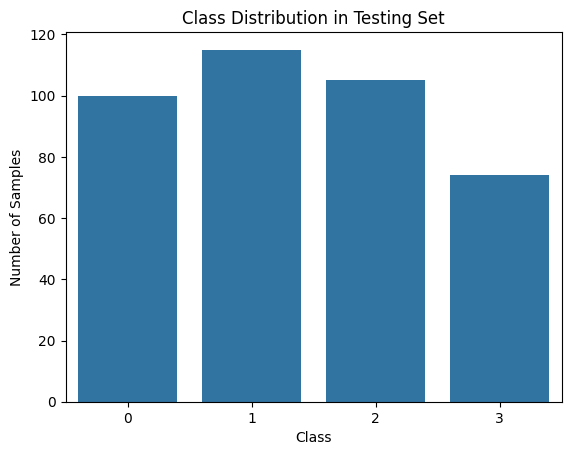

In [8]:
visualize_class_distribution(test_y, "Class Distribution in Testing Set")

In [9]:
def check_class_imbalance(labels):
  class_counts = {}
  for label in labels:
    if label not in class_counts:
      class_counts[label] = 0
    class_counts[label] += 1

  print("Class Counts:")
  for label, count in class_counts.items():
    print(f"Class {label}: {count}")

print("Class imbalance in the training set:")
check_class_imbalance(train_y)
print("\nClass imbalance in the validation set:")
check_class_imbalance(val_y)
print("\nClass imbalance in the testing set:")
check_class_imbalance(test_y)

Class imbalance in the training set:
Class Counts:
Class 1: 503
Class 2: 234
Class 3: 490
Class 0: 495

Class imbalance in the validation set:
Class Counts:
Class 3: 157
Class 2: 81
Class 1: 166
Class 0: 170

Class imbalance in the testing set:
Class Counts:
Class 3: 74
Class 2: 105
Class 0: 100
Class 1: 115



Class: glioma_tumor


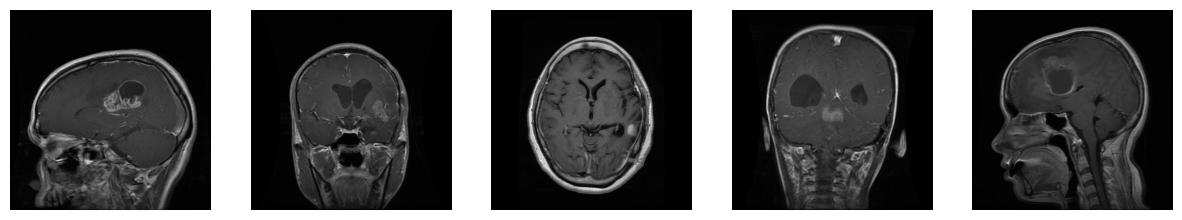


Class: meningioma_tumor


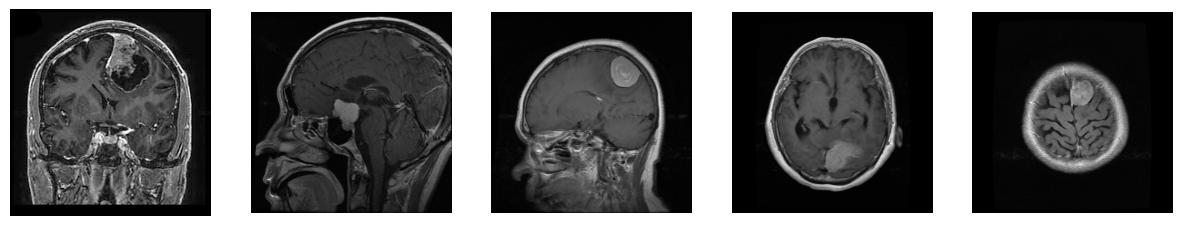


Class: pituitary_tumor


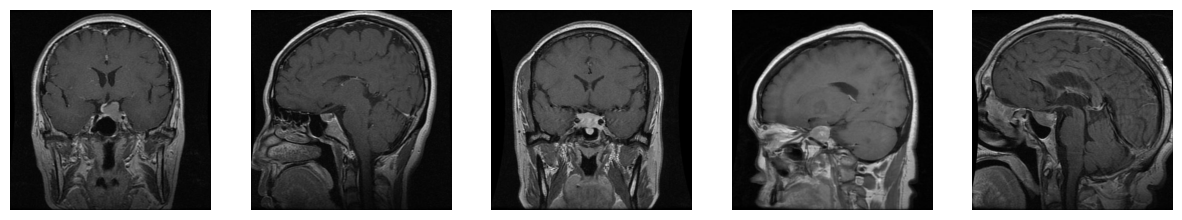


Class: no_tumor


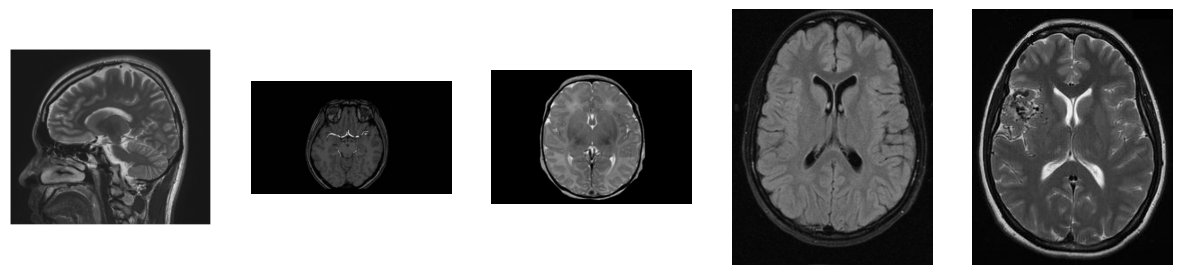

In [10]:
import matplotlib.pyplot as plt
import os
import random

# Cerinta 4
def visualize_images_by_class(data_dir, num_images_per_class=5):
  class_names = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
  for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
      print(f"\nClass: {class_name}")

      all_image_paths = [os.path.join(class_dir, image_name) for image_name in os.listdir(class_dir)]

      image_paths = random.sample(all_image_paths, num_images_per_class)

      plt.figure(figsize=(15, 5))

      for i, image_path in enumerate(image_paths):
        img = plt.imread(image_path)
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(img)
        plt.axis('off')
      plt.show()


visualize_images_by_class('/content/Training', num_images_per_class=5)

In [11]:
# Cerinta 5a

def check_channel_consistency():
  channel_counts = set()
  train_image_paths, train_labels = get_image_list("/content/Training")
  test_image_paths, test_labels = get_image_list("/content/Testing")
  for i in range(len(train_image_paths)):
    image = Image.open(train_image_paths[i])
    channel_counts.add(len(image.getbands()))

  print("Channel counts:", channel_counts)
  return len(channel_counts) == 1

print("Train dataset channel consistency:", check_channel_consistency())
print("Test dataset channel consistency:", check_channel_consistency())

def ensure_channel_uniformity(dataset, target_channels=1):
  for i in range(len(dataset)):
    image, label = dataset[i]

    if len(image.getbands()) != target_channels:
      image = image.convert('RGB')

    dataset.image_paths[i] = image



Channel counts: {3}
Train dataset channel consistency: True
Channel counts: {3}
Test dataset channel consistency: True


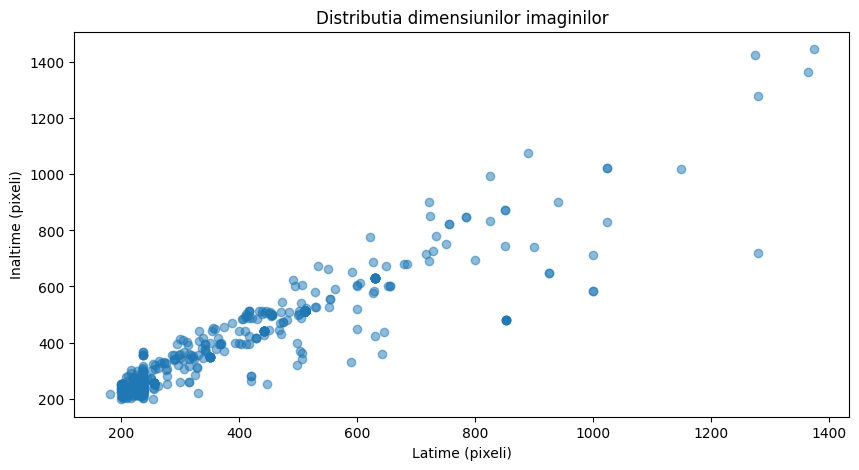

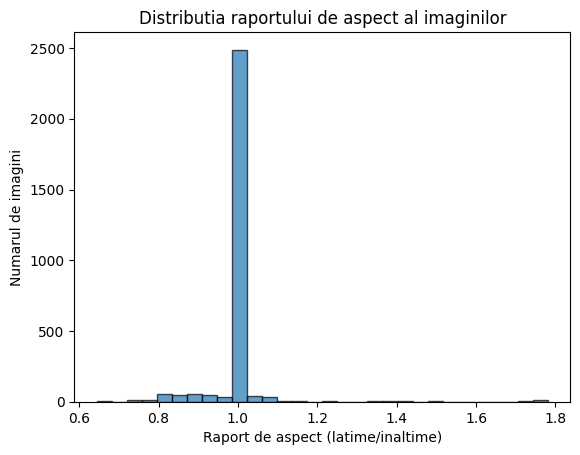

In [ ]:
# Cerinta 5b
def check_image_size(data_dir):
  latimi = []
  inaltimi = []
  aspect_ratio = []

  class_names = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
  for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    # print(class_dir)
    for nume_fisier in os.listdir(class_dir):
      if nume_fisier.endswith(('.jpg', '.jpeg', '.png')):
          image_path = os.path.join(class_dir, nume_fisier)
          # print(image_path)
          image = Image.open(image_path)
          width, height = image.size
          latimi.append(width)
          inaltimi.append(height)
          aspect_ratio.append(width/height)
          image.close()

  plt.figure(figsize=(10, 5))
  plt.scatter(latimi, inaltimi, alpha=0.5)
  plt.title("Distributia dimensiunilor imaginilor")
  plt.xlabel("Latime (pixeli)")
  plt.ylabel("Inaltime (pixeli)")
  plt.show()

  plt.hist(aspect_ratio, bins=30, edgecolor='black', alpha=0.5)
  plt.title("Distributia raportului de aspect al imaginilor")
  plt.xlabel("Raport de aspect (latime/inaltime)")
  plt.ylabel("Numarul de imagini")
  plt.show()


check_image_size('/content/Training')

In [13]:
def resize_images(data_dir, target_size=(256, 256)):
  for class_name in os.listdir(data_dir):
    uniform = 0
    not_uniform = 0
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
      for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)

        image = Image.open(image_path)

        image = image.resize(target_size)
        image.save(image_path)

# resize_images('/content/Training')
# resize_images('/content/Testing')

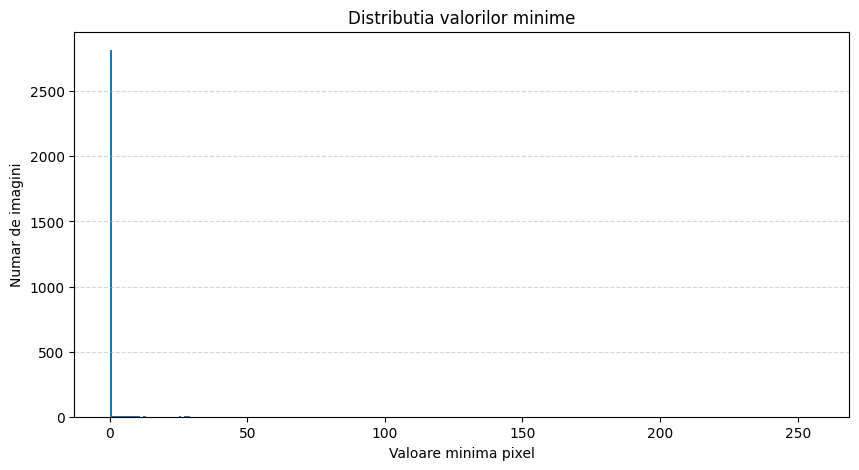

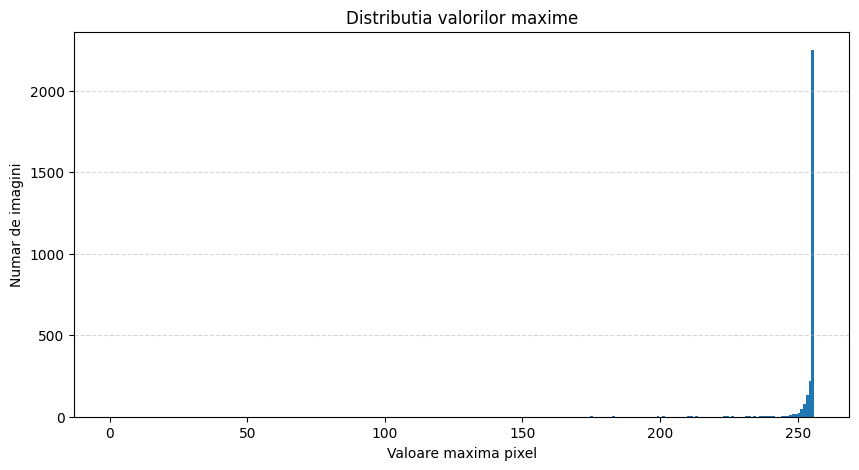

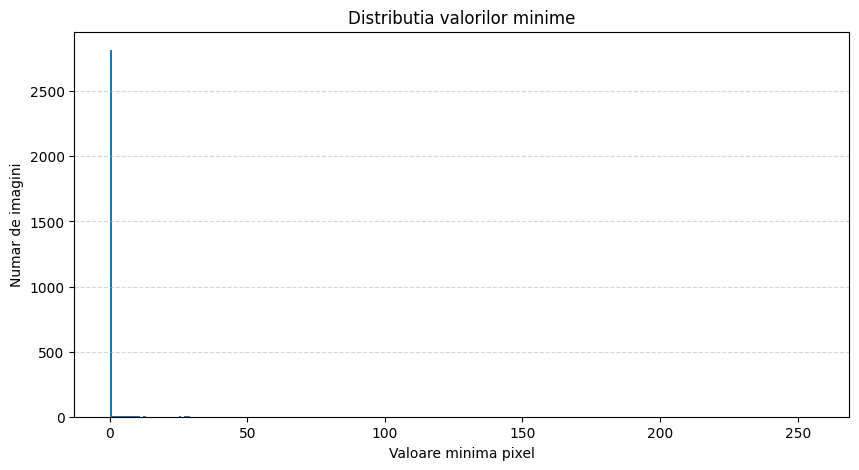

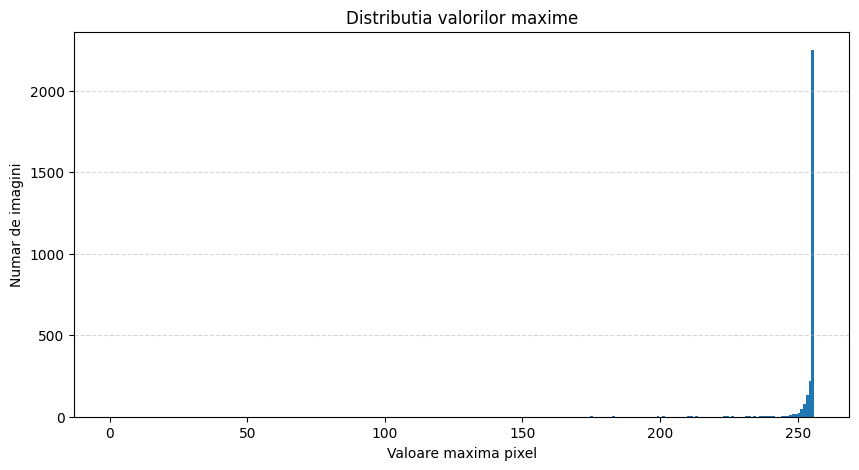

In [14]:
# Cerinta 5 c

def norm_pixel_values(data_dir):
  class_names = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
  for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for nume_fisier in os.listdir(class_dir):
      if nume_fisier.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(class_dir, nume_fisier)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        min_val = np.min(image)
        max_val = np.max(image)

        normalized_image = (image - min_val) / (max_val - min_val)
        normalized_image = normalized_image * 255
        normalized_image = normalized_image.astype(np.uint8)
        cv2.imwrite(image_path, normalized_image)

def check_normalization_distribution_pixel_values(data_dir):
  min_values = []
  max_values = []
  class_names = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
  for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for nume_fisier in os.listdir(class_dir):
      image_path = os.path.join(class_dir, nume_fisier)
      normalized_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      min_val = np.min(normalized_image)
      max_val = np.max(normalized_image)

      min_values.append(min_val)
      max_values.append(max_val)


  plt.figure(figsize=(10, 5))
  plt.hist(min_values, 255, [0, 256])
  plt.title("Distributia valorilor minime")

  plt.xlabel("Valoare minima pixel")
  plt.ylabel("Numar de imagini")
  plt.grid(axis='y', linestyle='--', alpha=0.5)
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.hist(max_values, 255, [0, 256])
  plt.title("Distributia valorilor maxime")
  plt.xlabel("Valoare maxima pixel")
  plt.ylabel("Numar de imagini")
  plt.grid(axis='y', linestyle='--', alpha=0.5)
  plt.show()


check_normalization_distribution_pixel_values('/content/Training')

# norm('/content/Training')
# norm('/content/Testing')
check_normalization_distribution_pixel_values('/content/Training')

**# Cerinta 6**

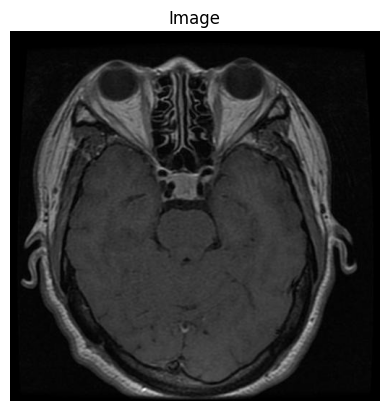

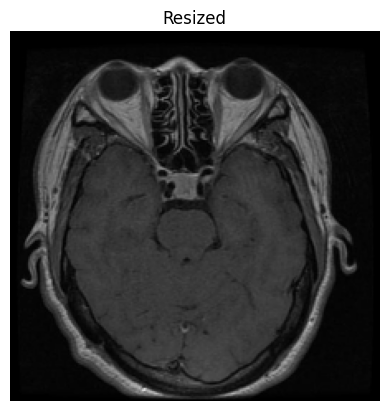

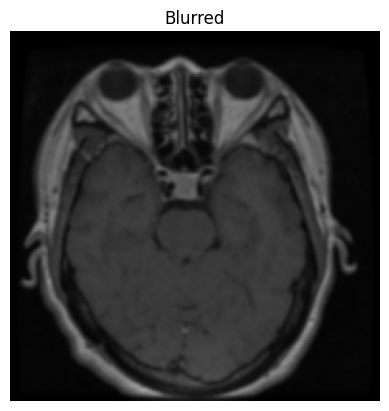

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


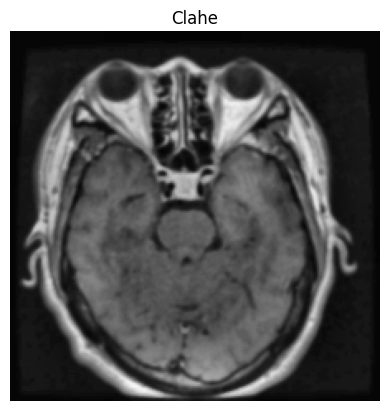

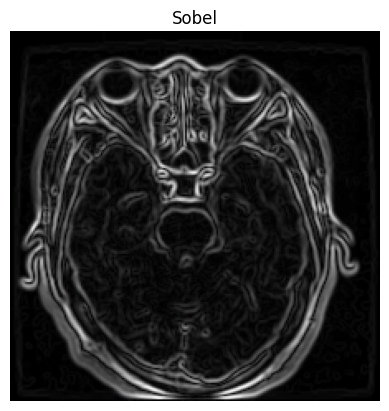

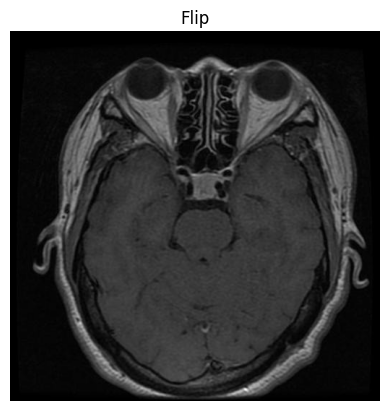

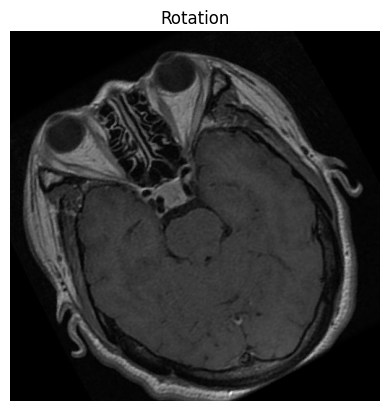

In [15]:
from torchvision import transforms
import torchvision.transforms.functional as F

class Transform_to_apply:
  def __call__(self, image):

    image = resize_image(image)
    image = GaussianBlur(image)
    image = apply_clahe(image)

    image = Image.fromarray(image)

    return image

def GaussianBlur(image_cv2):
  blurred_image = cv2.GaussianBlur(image_cv2, (5, 5), 1.0)
  return blurred_image


def sobel_edge_detection(image_cv2):
  grad_x = cv2.Sobel(image_cv2, cv2.CV_64F, 1, 0, ksize=3)
  grad_y = cv2.Sobel(image_cv2, cv2.CV_64F, 0, 1, ksize=3)

  gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

  gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

  return gradient_magnitude

def apply_clahe(image_cv2):
  import albumentations as A

  cl = A.CLAHE(p=1)
  clahe = cl(image=image_cv2)["image"]

  return clahe

def background_subtract(image_cv2):
  img = fgbg.apply(image_cv2)

  return img

def resize_image(image_cv2):
   image_cv2 = cv2.resize(image_cv2, (224, 224))
   return image_cv2

transforms_train = transforms.Compose([
    Transform_to_apply(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(60),
    transforms.ToTensor()
])

transforms_test = transforms.Compose([
    Transform_to_apply(),
    transforms.ToTensor()
])
def img_plt(img, title):
  plt.imshow(img)
  plt.title(title)
  plt.axis('off')
  plt.show()

def transform_image_show():
  image = cv2.imread(train_x[444])
  img_plt(image, "Image")

  resized_image = resize_image(image)
  img_plt(resized_image, "Resized")

  blurred_image = GaussianBlur(resized_image)
  img_plt(blurred_image, "Blurred")

  clahe_image = apply_clahe(blurred_image)
  img_plt(clahe_image, "Clahe")

  edge_image = sobel_edge_detection(clahe_image)
  img_plt(edge_image, "Sobel")

  image_pil = Image.fromarray(image)

  horizontal_flip = transforms.RandomHorizontalFlip(p=1)
  h_flip = horizontal_flip(image_pil)
  img_plt(np.array(h_flip), "Flip")

  rotation_transform = transforms.RandomRotation(60)
  rotated_image = rotation_transform(image_pil)
  img_plt(np.array(rotated_image), "Rotation")

transform_image_show()

**Cerinta 7**

**Incarcarea datelor**

In [16]:
train_x, train_y, val_x, val_y = get_splited_train_data()
test_x, test_y = get_test_data()



train_ds = BrainTumorDataset(train_x, train_y,transforms_train, "train")
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)


val_ds = BrainTumorDataset(val_x, val_y,transforms_train, "validation")
val_loader = DataLoader(val_ds, batch_size=32)

test_ds = BrainTumorDataset(test_x, test_y, transforms_test, "test")
test_loader = DataLoader(test_ds, batch_size=32)

**Definirea modelului**

In [21]:
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 4)

use_cuda = torch.cuda.is_available()
device = "cuda"

model.to(device)
# print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Functii de pierdere si optimizatorului**

In [22]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

**Antrenare si Validare**

In [23]:

# Training loop
epochs = 12
auroc = AUROC(task="multiclass", num_classes=4, average='weighted')
auroc = auroc.to(device)
train_loss_list = []
validation_loss_list = []
train_accuracy_list = []
validation_accuracy_list = []
performance_epoch = []
best_performance = 0
for epoch in range(epochs):
  print("-" * 10)
  print(f"epoch {epoch + 1}/{epochs}")
  model.train()
  epoch_loss = 0
  correct_train_preds = 0
  total_train_samples = 0
  step = 0
  for batch_data in train_loader:
      step += 1
      inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
      # Reset the b value
      optimizer.zero_grad()
      # Delete the extra dimension
      inputs = inputs.squeeze(1)
      outputs = model(inputs.float())
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
      epoch_len = len(train_ds) // train_loader.batch_size

      _, predicted = torch.max(outputs.data, 1)
      correct_train_preds += (predicted == labels).sum().item()
      total_train_samples += labels.size(0)

  train_accuracy = correct_train_preds / total_train_samples
  train_accuracy_list.append(train_accuracy)

  epoch_loss /= step
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
  train_loss_list.append(epoch_loss)

  # Validation loop
  model.eval()
  val_loss = 0
  val_acc = 0
  total_val_samples = 0
  probabilities = []
  targets = []
  with torch.no_grad():
    for data, target in val_loader:
      data, target = data.to(device), target.to(device)
      data = data.squeeze(1)
      output = model(data.float())
      loss = loss_function(output, target)
      val_loss += loss.item()

      _, predicted = torch.max(output.data, 1)
      val_acc += (predicted == target).sum().item()
      total_val_samples += target.size(0)

      probs = torch.softmax(output, dim=1)
      probabilities.append(probs)
      targets.append(target)


  validation_accuracy = val_acc / total_val_samples
  validation_accuracy_list.append(validation_accuracy)

  probabilities = torch.cat(probabilities)
  targets = torch.cat(targets)

  performance = auroc(probabilities, targets)
  print(f"Performance: {performance:.4f}")
  performance_epoch.append(performance)
  if performance > best_performance:
    best_performance = performance
    torch.save(model.state_dict(), "best_metric_model.pth")
    print(f"New best Performance!: {best_performance:.4f}")

  print(f"Validation Loss: {val_loss/len(val_loader)}")
  validation_loss_list.append(val_loss/len(val_loader))

----------
epoch 1/12
1/53, train_loss: 1.6283
2/53, train_loss: 4.2078
3/53, train_loss: 4.1843
4/53, train_loss: 6.5527
5/53, train_loss: 11.9837
6/53, train_loss: 10.3274
7/53, train_loss: 11.5504
8/53, train_loss: 6.5163
9/53, train_loss: 14.0008
10/53, train_loss: 7.9134
11/53, train_loss: 4.2658
12/53, train_loss: 2.1455
13/53, train_loss: 3.4395
14/53, train_loss: 3.2604
15/53, train_loss: 5.8886
16/53, train_loss: 2.3768
17/53, train_loss: 2.4054
18/53, train_loss: 2.0433
19/53, train_loss: 5.4686
20/53, train_loss: 2.7271
21/53, train_loss: 1.3723
22/53, train_loss: 1.8566
23/53, train_loss: 1.7636
24/53, train_loss: 2.9254
25/53, train_loss: 1.2985
26/53, train_loss: 3.8819
27/53, train_loss: 1.6224
28/53, train_loss: 2.6416
29/53, train_loss: 11.0354
30/53, train_loss: 1.4790
31/53, train_loss: 1.1439
32/53, train_loss: 2.4648
33/53, train_loss: 6.5109
34/53, train_loss: 1.3602
35/53, train_loss: 1.8473
36/53, train_loss: 1.9452
37/53, train_loss: 3.4683
38/53, train_loss: 1

**Testare**

Validation Loss: 1.5530391567283206, Validation Accuracy: 0.30139372822299654
Accuracy: 0.30139372822299654
Precision: 0.5261806250800849
Recall: 0.43908629441624364
F1-score: 0.40769287743391264


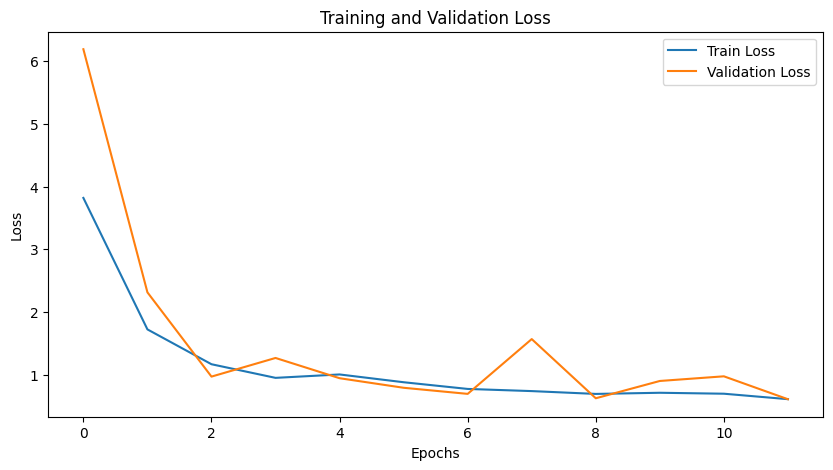

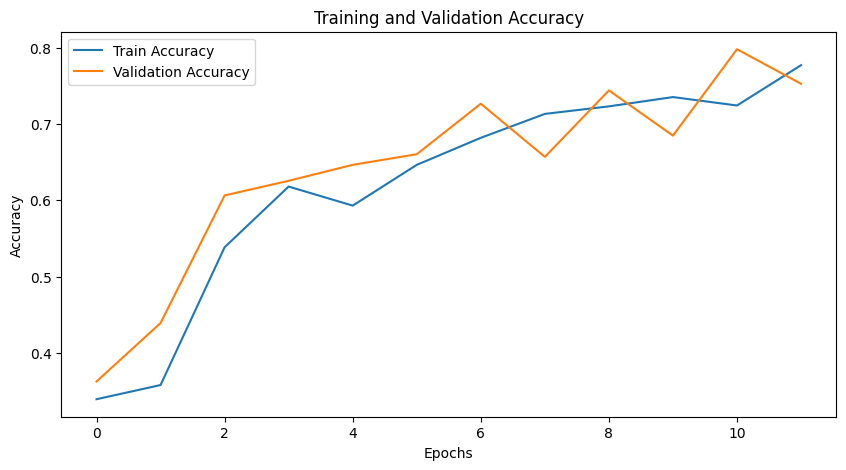

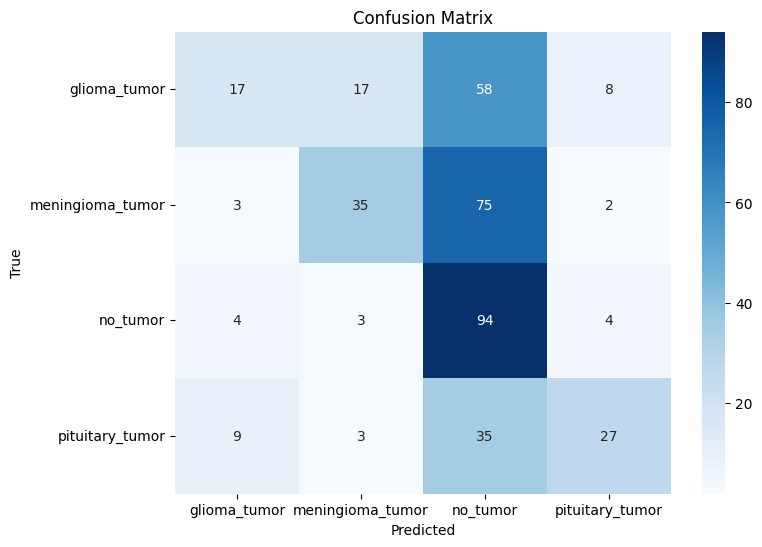

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


model.eval()
y_true = []
y_pred = []
val_loss = 0
val_acc = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data = data.squeeze(1)
    output = model(data.float())
    loss = loss_function(output, target)
    val_loss += loss.item()

    _, predicted = torch.max(output.data, 1)
    val_acc += (predicted == target).sum().item()

    y_true.extend(target.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

  print(f"Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_acc/len(val_ds)}")

accuracy = val_acc/len(val_ds)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
